# キャビン番号に関する特徴量エンジニアリング

In [252]:
import pandas as pd
import pipeline
import importlib
import numpy as np
import japanize_matplotlib

importlib.reload(pipeline)

from pipeline.baseline import Baseline
from pipeline.age import Age
import matplotlib.pyplot as plt

In [253]:
df_titanic_train = pd.read_csv("../../data/train.csv")

## Cabin番号と生死の関係
- 棒グラフで可視化してみる

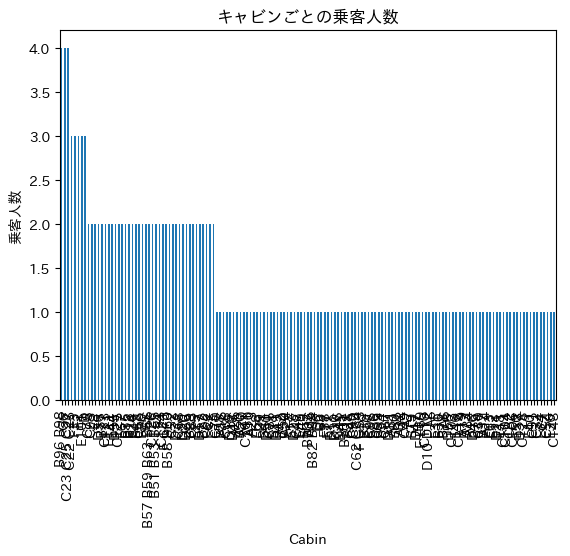

In [254]:
# Cabin列の欠損値を含む行を削除
df_non_missing_cabin = df_titanic_train.dropna(subset=["Cabin"])

cabin_counts = df_non_missing_cabin["Cabin"].value_counts()


cabin_counts.plot(kind="bar")
plt.xlabel("Cabin")
plt.ylabel("乗客人数")
plt.title("キャビンごとの乗客人数")
plt.show()

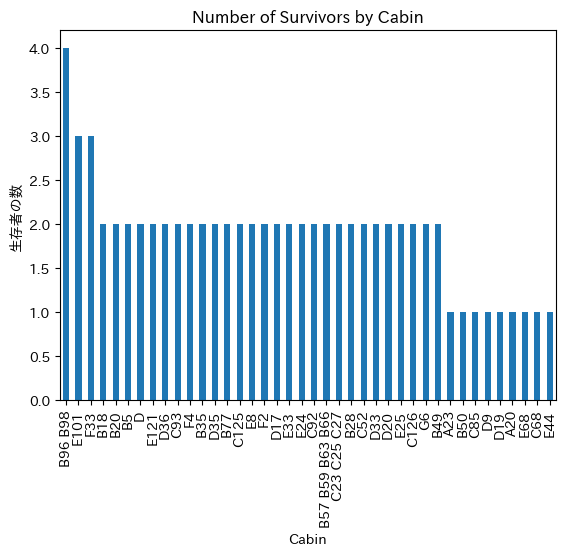

In [255]:
# Cabin列の欠損値を含む行を削除
df_non_missing_cabin = df_titanic_train.dropna(subset=["Cabin"])

cabin_survived_counts = df_non_missing_cabin[df_non_missing_cabin["Survived"] == 1][
    "Cabin"
].value_counts()

# 上位5つのキャビンのみを抽出
top_cabins = cabin_survived_counts.head(40)

# 生存者数の可視化
top_cabins.plot(kind="bar")
plt.xlabel("Cabin")
plt.ylabel("生存者の数")
plt.title("Number of Survivors by Cabin")
plt.show()

### 離散化

#### Cabinの種類を確認

In [256]:
# Cabin列の欠損値を含む行を削除
df_non_missing_cabin = df_titanic_train.dropna(subset=["Cabin"])

# Cabin列から接頭辞を抽出
df_non_missing_cabin["Cabin_prefix"] = df_non_missing_cabin["Cabin"].str[0]

# 接頭辞の種類を取得
cabin_prefix_types = df_non_missing_cabin["Cabin_prefix"].unique()

print("Cabin prefixes:", cabin_prefix_types)
print("Number of unique Cabin prefixes:", len(cabin_prefix_types))

Cabin prefixes: ['C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
Number of unique Cabin prefixes: 8


/var/folders/1w/52jfb36j6sg557p8z_gknglh0000gn/T/ipykernel_69398/448145639.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_missing_cabin["Cabin_prefix"] = df_non_missing_cabin["Cabin"].str[0]


#### Cavinを元に離散化

In [257]:
# Cabinの先頭文字を基に離散化
cabin_mapping = {
    "A": 0,
    "B": 1,
    "C": 2,
    "D": 3,
    "E": 4,
    "F": 5,
    "G": 6,
    "T": 7,
}
df_non_missing_cabin["Cabin_bin"] = (
    df_non_missing_cabin["Cabin"].str[0].map(cabin_mapping)
)

/var/folders/1w/52jfb36j6sg557p8z_gknglh0000gn/T/ipykernel_69398/2457198703.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_missing_cabin["Cabin_bin"] = (


離散化したCabinごとの生存数をプロット

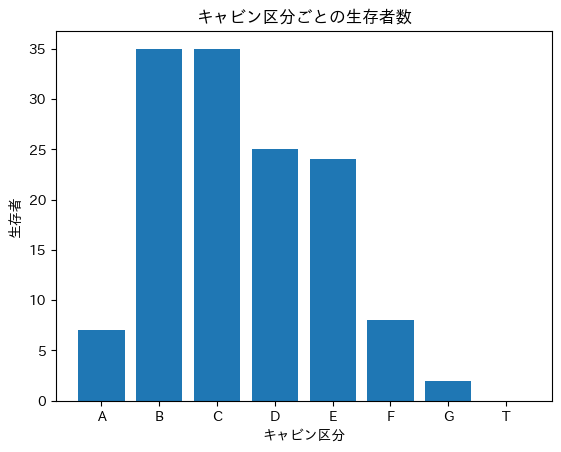

In [258]:
survival_counts = df_non_missing_cabin.groupby("Cabin_bin")["Survived"].sum()
cabin_labels = [k for k, v in sorted(cabin_mapping.items(), key=lambda item: item[1])]
plt.bar(cabin_labels, survival_counts)
plt.xlabel("キャビン区分")
plt.ylabel("生存者")
plt.title("キャビン区分ごとの生存者数")
plt.show()

In [259]:
X, y, id = (
    df_titanic_train[["Pclass", "Fare", "Age"]],
    df_titanic_train["Survived"],
    df_titanic_train["PassengerId"],
)
X_add, y_add, id_add = (
    df_non_missing_cabin[["Fare", "Age", "Pclass"]],
    df_non_missing_cabin["Survived"],
    df_non_missing_cabin["PassengerId"],
)

bl = Baseline(input_X=X, input_y=y, input_id=id)
bl_add = Baseline(input_X=X_add, input_y=y_add, input_id=id_add)

impls, scores = bl.create_model()
impls_add, scores_add = bl_add.create_model()

print("Scores:", scores)
print("Scores_add:", scores_add)
print(impls)
print(impls_add)

/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipeline/age.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.__df_age.loc[:, "Age_bin"] = pd.cut(
/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipeline/age.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.__df_age.loc[:, "Age_bin"] = pd.cut(


Scores: 0.6824555897307137
Scores_add: 0.6371951219512195
   feature  importance
0   Pclass         117
1     Fare        2333
2  Age_bin         538
   feature  importance
0     Fare         508
1   Pclass          28
2  Age_bin         121


## Cabinの欠損値処理
- SibSp ・ Parch ・Ticketからの乗客同士の関係性のグルーピング

#### チケット番号が連番の場合、苗字が同じ、SibSp ・ Parchの数が同じなどの傾向を見る

In [260]:
df_titanic_train_cabin_missing = df_titanic_train.copy()

df_titanic_train_cabin_missing["Ticket"].min()

'110152'

In [261]:
# Nameから苗字を抽出
df_titanic_train_cabin_missing["LastName"] = df_titanic_train_cabin_missing[
    "Name"
].apply(lambda x: x.split(",")[0].strip())

# FamilyIdの初期化
df_titanic_train_cabin_missing["FamilyId"] = 0

# 苗字ごとにグループ化してFamilyIdを設定
unique_family_id = 1
family_id_map = {}

for idx, row in df_titanic_train_cabin_missing.iterrows():
    last_name = row["LastName"]
    if last_name not in family_id_map:
        family_id_map[last_name] = unique_family_id
        unique_family_id += 1
    df_titanic_train_cabin_missing.at[idx, "FamilyId"] = family_id_map[last_name]

# 最後に不要なLastName列を削除
df_titanic_train_cabin_missing = df_titanic_train_cabin_missing.drop(
    columns=["LastName"]
)

#### FamilyIdを元にCabin番号を割り当てる

In [262]:
# FamilyIdごとにCabinの欠損値を補完
cabin_map = {}

for idx, row in df_titanic_train_cabin_missing.iterrows():
    family_id = row["FamilyId"]
    cabin = row["Cabin"]
    if pd.notna(cabin):
        cabin_map[family_id] = cabin

for idx, row in df_titanic_train_cabin_missing.iterrows():
    family_id = row["FamilyId"]
    if pd.isna(row["Cabin"]) and family_id in cabin_map:
        df_titanic_train_cabin_missing.at[idx, "Cabin"] = cabin_map[family_id]

#### 離散化

In [263]:
# Cabinの先頭文字を基に離散化
cabin_mapping = {
    "A": 0,
    "B": 1,
    "C": 2,
    "D": 3,
    "E": 4,
    "F": 5,
    "G": 6,
    "T": 7,
}
df_titanic_train_cabin_missing["Cabin_bin"] = (
    df_titanic_train_cabin_missing["Cabin"].str[0].map(cabin_mapping)
)

In [264]:
X, y, id = (
    df_titanic_train[["Pclass", "Fare", "Age"]],
    df_titanic_train["Survived"],
    df_titanic_train["PassengerId"],
)
X_add, y_add, id_add = (
    df_titanic_train_cabin_missing[["Pclass", "Fare", "Age", "Cabin_bin"]],
    df_titanic_train_cabin_missing["Survived"],
    df_titanic_train_cabin_missing["PassengerId"],
)

bl = Baseline(input_X=X, input_y=y, input_id=id)
bl_add = Baseline(input_X=X_add, input_y=y_add, input_id=id_add)

impls, scores = bl.create_model()
impls_add, scores_add = bl_add.create_model()

print("Scores:", scores)
print("Scores_add:", scores_add)
print(impls)
print(impls_add)

/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipeline/age.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.__df_age.loc[:, "Age_bin"] = pd.cut(
/Users/yuramaru/src/kaggle-practice/titanic/src/feature_engineering/pipeline/age.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.__df_age.loc[:, "Age_bin"] = pd.cut(


Scores: 0.6824555897307137
Scores_add: 0.701506496767309
   feature  importance
0   Pclass         117
1     Fare        2333
2  Age_bin         538
     feature  importance
0     Pclass         100
1       Fare        2116
2  Cabin_bin         247
3    Age_bin         530


### Cabin番号の属性が固まっているかの検証

/var/folders/1w/52jfb36j6sg557p8z_gknglh0000gn/T/ipykernel_69398/2308805007.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_validation.groupby(["Cabin_bin", "Age_bin"]).size().unstack().fillna(0)


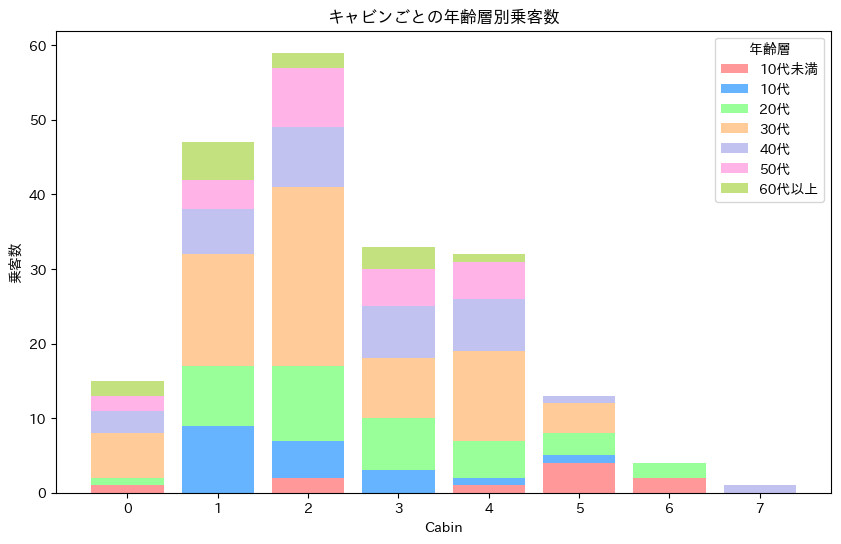

In [270]:
age = Age(df_non_missing_cabin)
df_validation = age.discretization()

# Cabinの欠損値を持つ行を除外
df_validation = df_validation.dropna(subset=["Cabin"])


# CabinとSexでグループ化してカウント
age_bin_counts = (
    df_validation.groupby(["Cabin_bin", "Age_bin"]).size().unstack().fillna(0)
)

# プロットの準備
cabin_labels = age_bin_counts.index.tolist()
age_bins = age_bin_counts.columns.tolist()

x = range(len(cabin_labels))

# プロット
fig, ax = plt.subplots(figsize=(10, 6))

# 色の設定
colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99", "#c2c2f0", "#ffb3e6", "#c4e17f"]

# 各年齢層ごとに積み上げ棒グラフを作成
bottom_counts = [0] * len(cabin_labels)
for idx, age_bin in enumerate(age_bins):
    counts = age_bin_counts[age_bin]
    ax.bar(x, counts, label=age_bin, bottom=bottom_counts, color=colors[idx])
    bottom_counts = [sum(values) for values in zip(bottom_counts, counts)]

plt.xticks(x, cabin_labels)
plt.xlabel("Cabin")
plt.ylabel("乗客数")
plt.title("キャビンごとの年齢層別乗客数")
plt.legend(title="年齢層")

plt.show()

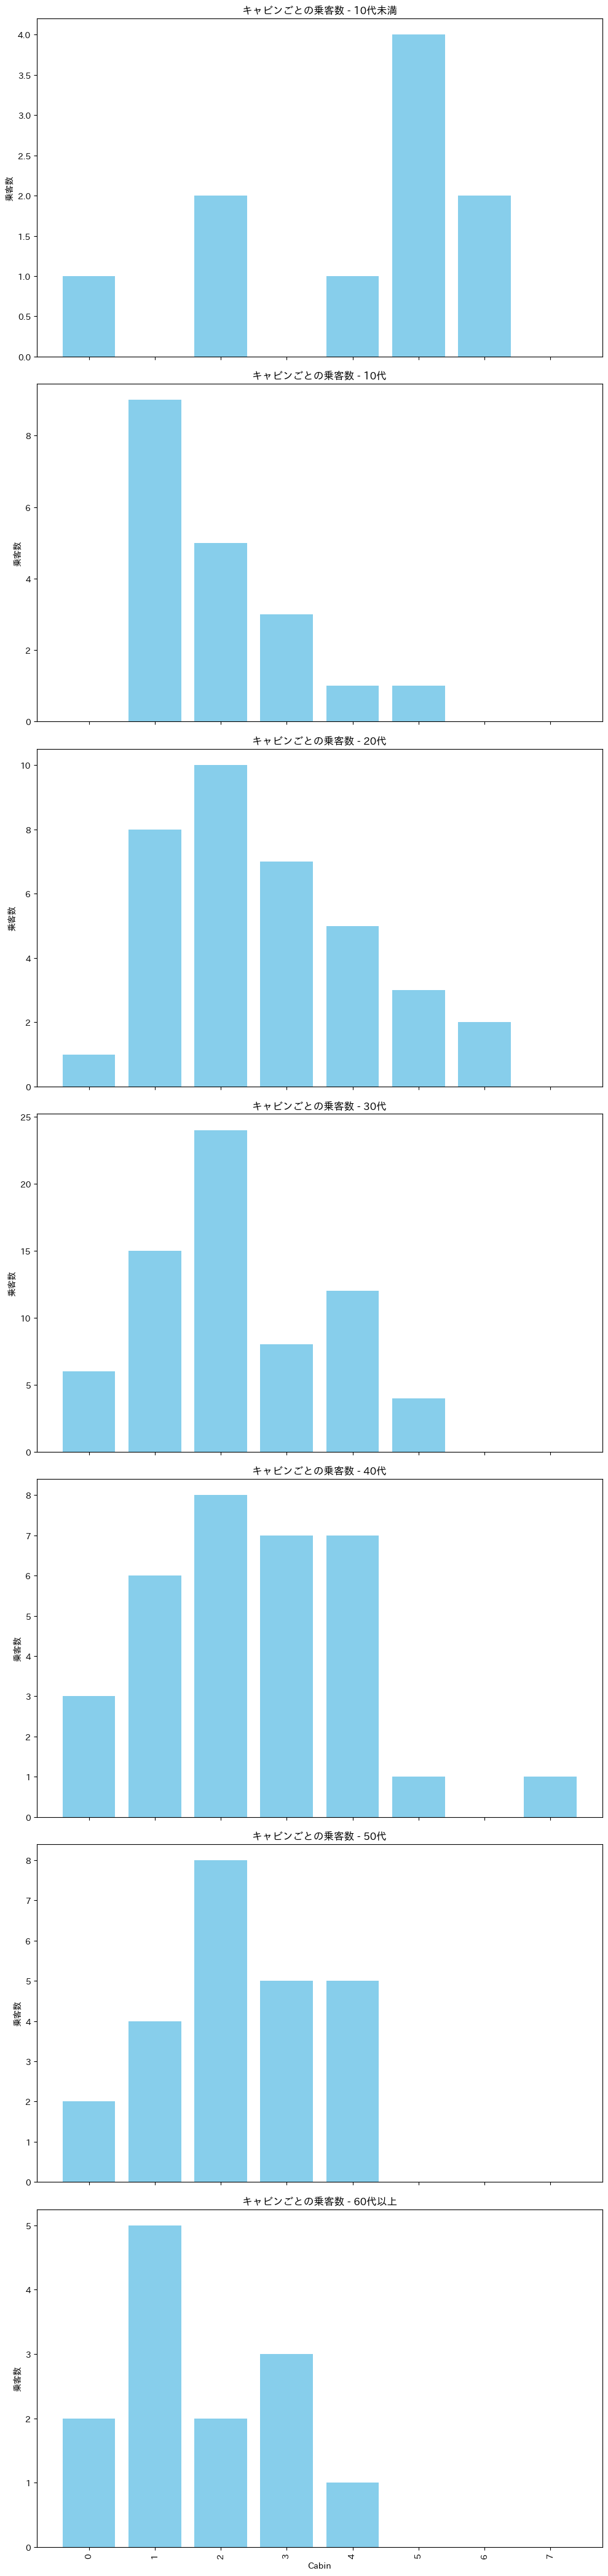

In [271]:
# プロットの準備
cabin_labels = age_bin_counts.index.tolist()
age_bins = age_bin_counts.columns.tolist()

# 各Age_binごとにグラフをプロット
fig, axes = plt.subplots(len(age_bins), 1, figsize=(10, 6 * len(age_bins)), sharex=True)

for idx, age_bin in enumerate(age_bins):
    counts = age_bin_counts[age_bin]
    ax = axes[idx]
    ax.bar(cabin_labels, counts, label=age_bin, color="skyblue")
    ax.set_ylabel("乗客数")
    ax.set_title(f"キャビンごとの乗客数 - {age_bin}")

plt.xlabel("Cabin")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()